<a href="https://colab.research.google.com/github/atsss/Deep-Learning-for-Computer-Vision-with-Python-and-TensorFlow/blob/main/Human_Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data download


> https://gemini.google.com/app/de3364032c27214c



In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

100%|██████████| 309M/309M [00:02<00:00, 121MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4


In [2]:
!pwd

/content


In [6]:
!mv /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4 /content/

In [7]:
!mv /content/4 /content/dataset

## Define variables

In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image

In [23]:
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [2]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

In [3]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

## Dataset Loading

In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [16]:
# for i in val_dataset.take(1):
#   print(i)

## Dataset Visualization

1
1
0
0
0
2
0
2
1
2
1
1
0
0
1
1


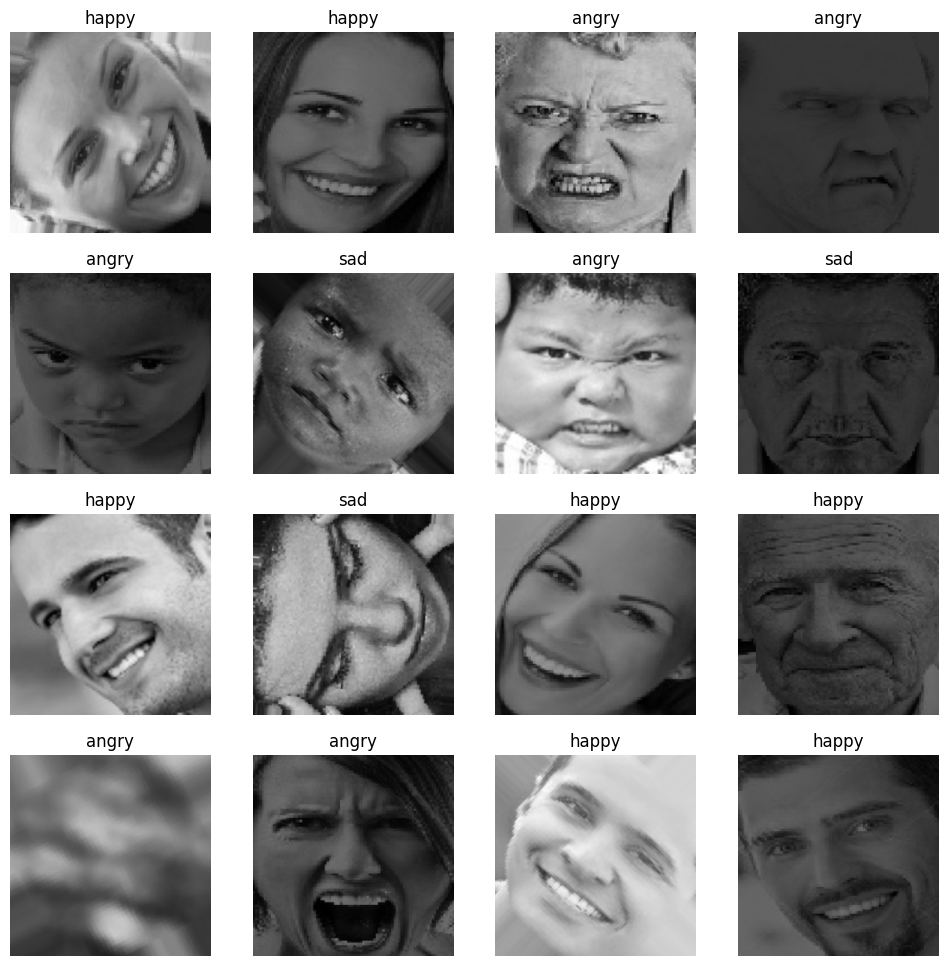

In [18]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    # print(tf.argmax(labels[i], axis = 0).numpy())
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

## Dataset Preparation
- prefetchとは？
  - 事前読み込み: TensorFlowのデータパイプラインにおいて、次のバッチのデータを事前に読み込んでおく処理です。
  - 並列処理: GPUやTPUなどのアクセラレータが次の計算の準備ができる間に、データの読み込みを行うことで、処理のオーバーヘッドを減らし、学習の効率を向上させることができます。
  - tf.data.AUTOTUNE: この引数は、TensorFlowに最適な並列化のレベルを自動的に選択させることを意味します。システムの資源やデータセットの特性に合わせて、最適なパフォーマンスが得られるように、TensorFlowが自動的にチューニングを行います。

In [20]:
training_dataset = (
    train_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [21]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [24]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

### コードの説明
このコードは、TensorFlowのKerasを用いて、画像の前処理を行うためのレイヤーを定義しています。具体的には、画像のサイズを変更し、ピクセル値を正規化する処理を行っています。

#### 各レイヤーの役割
- Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]):
  - 画像のサイズを、CONFIGURATION["IM_SIZE"] × CONFIGURATION["IM_SIZE"] に変更します。
  - 画像の縦横比が維持されない可能性があるため、アスペクト比を維持したい場合は、別のレイヤーを使用する必要があります。
- Rescaling(1./255):
  - 画像のピクセル値を0から255の範囲から、0から1の範囲に正規化します。
  - 多くのニューラルネットワークでは、入力データは0から1の範囲に正規化することが一般的です。

#### このレイヤー群の目的
- 画像の標準化:
  - 異なるサイズやピクセル値の範囲の画像を、統一的なサイズと範囲に揃えることで、ニューラルネットワークの学習を安定化させます。
- モデルへの入力準備:
  - ニューラルネットワークの多くは、0から1の範囲の入力データを期待するため、このレイヤーでデータを適切な形式に変換します。

#### 全体的な処理の流れ
1. 入力された画像が、Resizingレイヤーによって指定されたサイズにリサイズされます。
2. リサイズされた画像が、Rescalingレイヤーによって、ピクセル値が0から1の範囲に正規化されます。
3. 正規化された画像が、次のレイヤー（例えば、畳み込み層など）に渡されます。